In [2]:
from numpy import random

from torch.nn import Linear

from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Entities
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from IPython.display import Javascript

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
N_samples = 1000
N_rois = 15

In [47]:
def generate_syntetic_data(N_samples, N_rois):
    
    vals = random.standard_normal((N_samples, N_rois, N_rois))
    labels = random.randint(2, size = N_samples)
    
    for i in range(N_samples):
        if labels[i] == 0:
            vals[i,-1,-1] = 0.5 * random.random_sample()
        else:
            vals[i,-1,-1] = 0.5 * random.random_sample() + 0.5
            
    #TODO: make sure that symmetrified matrix values are corrcet     
    ## symmetrify(upper and lower trinagular values are not the same anymore)
    for i in range(vals.shape[0]):
        vals[i, :,:] = (vals[i, :,:] + vals[i, :,:].T) / 2        
    return vals, labels        


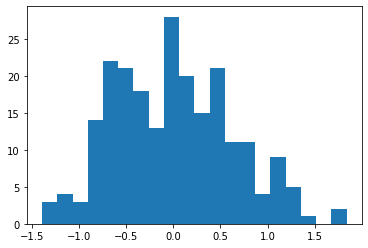

In [45]:
vals, labels = generate_syntetic_data(N_samples, N_rois)
_ = plt.hist(vals[0].flatten(), bins=20)

<AxesSubplot:>

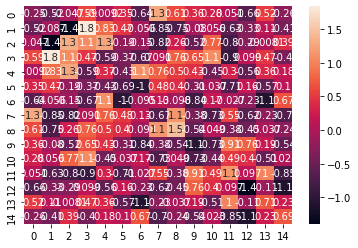

In [46]:
sns.heatmap(vals[0], annot=True)

In [21]:
vals[0,2,0] == vals[0,0,2]

True

In [54]:
lr = LogisticRegression(penalty='l1', solver='liblinear')

In [58]:
vals.reshape(N_samples, -1).shape

(1000, 225)

In [60]:
lr.fit(vals.reshape(N_samples, -1), labels)

LogisticRegression(penalty='l1', solver='liblinear')

In [62]:
lr.coef_.shape

(1, 225)

In [56]:
scores = cross_val_score(lr, vals.reshape(N_samples,-1), labels, cv=5, scoring='accuracy')

In [59]:
lr.coef_


AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [25]:
np.mean(scores)

0.961

In [26]:
def calculate_graph(vals, label, threshold=0.5):
    X = vals
    #X = np.eye(N_rois,N_rois)
    edge_indexes, edge_attres =[], []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i,j] > threshold:
                edge_indexes.append([i,j])
                edge_attres.append(X[i,j])
    return Data(x=torch.tensor(X), 
                edge_index=torch.tensor(np.array(edge_indexes).T),
                y=torch.tensor([label]))     

In [27]:
## Generate our Synthetic dataset
data_list = []
for i in range(N_samples):
    data = calculate_graph(vals[i,:,:], labels[i])
    data_list.append(data)

In [43]:
data_list[7]

Data(x=[15, 15], edge_index=[2, 66], y=[1])

In [29]:
# ## Generate MUTAG dataset

# data_list = TUDataset(root='data/TUDataset', name='MUTAG')

# print()
# print(f'Dataset: {data_list}:')
# print('====================')
# print(f'Number of graphs: {len(data_list)}')
# print(f'Number of features: {data_list.num_features}')
# print(f'Number of classes: {data_list.num_classes}')

In [30]:
data_list[2]

Data(x=[15, 15], edge_index=[2, 62], y=[1])

In [68]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, N_rois):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        # self.conv1 = GINConv(
        #               Sequential(Linear(N_rois, hidden_channels),
                    #    BatchNorm1d(hidden_channels), ReLU()))
        # self.conv2 = GINConv(Sequential(Linear(hidden_channels, hidden_channels),
                    #    BatchNorm1d(hidden_channels), ReLU()))

        self.conv1 = GCNConv(N_rois, hidden_channels)
        # self.bn1 = BatchNorm1d(hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.bn2 = BatchNorm1d(hidden_channels)
        #self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
        # self.bn3 = BatchNorm1d(hidden_channels)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        #x = F.dropout(x, p=0.6, training=self.training)
        # print(x.shape)
        # print(edge_index.shape)
        x = self.conv1(x, edge_index=edge_index)
        x = x.relu()
        # print(x.shape)
        # x = self.bn1(x)
        
        #x = F.dropout(x, p=0.5, training=self.training)
        # x = self.conv2(x, edge_index=edge_index)
        # x = x.relu()
        # x = self.bn2(x)

        #x = x.relu()
        #x = self.conv3(x, edge_index)

        # 2. Readout layer
        x_pool = global_max_pool(x, batch)  # [batch_size, hidden_channels]
        
        # x = F.dropout(x_pool, p=0.2, training=self.training)
        # x = self.bn3(x)

        # 3. Apply a final classifier
        #x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x_pool)
        # print(x.shape)
        
        return x, x_pool
        
    
    def compute_l1_loss(self, w):
          return torch.abs(w).sum()


In [70]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out, x_pool = model(data.x.type(dtype=torch.float).to(device), 
                     data.edge_index.to(device),
                     data.batch.to(device))  # Perform a single forward pass.
         
         loss = criterion(out, data.y.to(device))  # Compute the loss.
         # Compute L1 loss component
     #     l1_weight = 1
     #     l1_parameters = []
     #     for parameter in model.parameters():
     #          l1_parameters.append(parameter.view(-1))
     #     l1 = l1_weight * model.compute_l1_loss(torch.cat(l1_parameters))
      
      # Add L1 loss component
     #     loss += l1
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(model, loader, device):
     model.eval()

     correct = 0
     outs, labels =[], []
     for data in loader:  # Iterate in batches over the training/test dataset.
         out,x_pool = model(data.x.type(dtype=torch.float).to(device), 
                     data.edge_index.to(device),
                     data.batch.to(device))
            
         outs.append(x_pool.detach().cpu().numpy())
         labels.append(data.y.to(device).detach().cpu().numpy())
            
         pred = out.argmax(dim=1)  # Use the class with highest probability.
        

         correct += int((pred == data.y.to(device)).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset), outs, labels  # Derive ratio of correct predictions.


In [71]:
def run_model(X_train, X_val, device):

    train_loader = DataLoader(X_train, batch_size=24)
    val_loader   = DataLoader(X_val, batch_size=24)
    #test_loader = DataLoader(X_test, batch_size=8)
    
    model = GCN(hidden_channels=32, N_rois = N_rois).to(device)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Number of trainable parameters: ", params)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(1, 100):

        train(model, train_loader, criterion, optimizer, device)

        train_acc,outs, labels = test(model,train_loader, device=device)
        val_acc,outs, labels = test(model,val_loader, device=device)

        #test_acc = test(model,test_loader)
    
    return train_acc,val_acc,outs, labels     

In [72]:
train_accs,val_accs, test_accs =[], [], []

global device
device = "cpu"

num_folds = 2
kf = KFold(n_splits=num_folds)

for train_index, valid_index in kf.split(data_list):

    X_train = [data_list[ind] for ind in train_index]
    X_val   = [data_list[ind] for ind in valid_index]
    labels_train = [elem.y.item() for elem in X_train]
    labels_test  = [elem.y.item() for elem in X_val]

    train_acc, val_acc, outs, labels = run_model(X_train, X_val, device)

    print("Accuracy train: ", train_acc, " val:", val_acc)

    train_accs.append(train_acc)
    val_accs.append(val_acc)



Number of trainable parameters:  578
Accuracy train:  0.634  val: 0.51
Number of trainable parameters:  578
Accuracy train:  0.594  val: 0.5


In [ ]:

    
train_acc, val_acc, outs, labels = run_model(X_train, X_val)
print("Accuracy train: ", train_acc, " val:", val_acc)

In [ ]:
np.mean(train_accs)

In [ ]:
np.std(train_accs)

In [ ]:
np.mean(val_accs)

In [ ]:
np.std(val_accs)

In [73]:
#SAGEConv -> 0.736 +-0.138
#GCN -> 0.717 +-0.143
#SAGEConv (dropout) ->0.743+-0.126

In [74]:
## Проверим MUTAG dataset

In [75]:
outs =np.concatenate(outs)

In [76]:
 outs.shape

(1000, 32)

In [77]:
labels =np.concatenate(labels)

In [78]:
outputs_label1 =outs[labels==1]

In [79]:
outputs_label2 =outs[labels==0]

In [80]:
diff =outputs_label1.mean(axis=0) - outputs_label2.mean(axis=0)

In [81]:
diff

array([ 1.89174898e-10, -1.32664666e-03, -6.56655175e-09, -2.91038305e-11,
       -2.06778478e-03, -3.35829984e-03,  1.24473445e-08,  1.63709046e-10,
       -3.96539690e-09,  1.26662860e-02,  2.54964661e-02,  3.58340912e-09,
       -9.09494702e-13,  2.92326149e-07,  8.65838956e-10,  1.86249539e-02,
       -3.63797881e-11,  2.79903710e-02,  5.21231414e-09, -1.37515599e-09,
        7.17460580e-08, -1.90560427e-03,  1.08238964e-08,  2.21916707e-10,
       -1.21660531e-04,  3.98824795e-09, -2.53769523e-03,  3.04135028e-08,
       -4.04907041e-09, -1.81898940e-12, -1.63709046e-11,  1.63945515e-07],
      dtype=float32)

<AxesSubplot:>

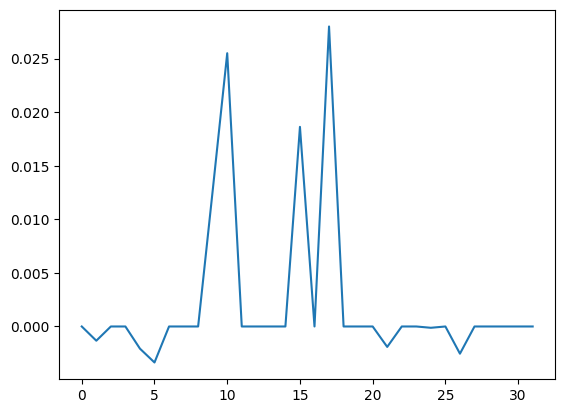

In [83]:
sns.lineplot(data=diff)

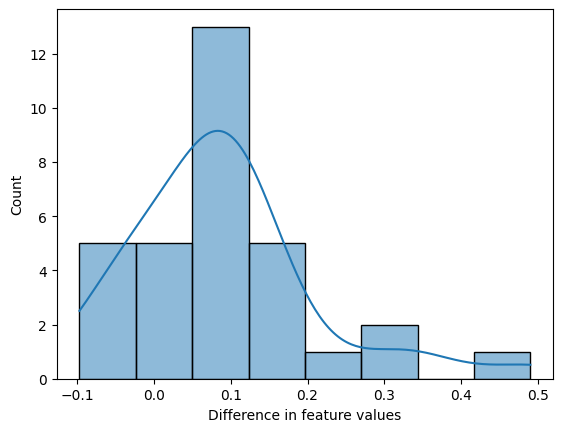

In [127]:
sns.histplot(diff, kde=True)
plt.xlabel('Difference in feature values')
plt.ylabel('Count')
plt.show()